# Bayesian Linear Regression Example 

Walkthrough of the important bits of the [Linear Regression tutorial from the numpyro docs](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html#Predictive-Utility-With-Effect-Handlers) purely for practice.



In [2]:
import os

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

plt.style.use("bmh")

In [5]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")

# standardize dataset
standardize = lambda x: (x - x.mean()) / x.std()

dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

dset.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,AgeScaled,MarriageScaled,DivorceScaled
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,0.022644,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.549802,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.048974,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,1.655123,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.266989,-0.927058


In [6]:
# MODEL
def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.2))
    M, A = 0.0, 0.0
    if marriage is not None:
        bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
        A = bA * age
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = a + M + A
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

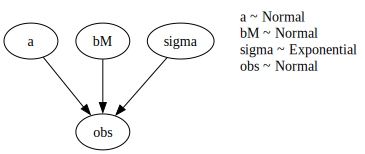

In [22]:
numpyro.render_model(model, (dset['MarriageScaled'].values,), render_distributions=True)

In [11]:
# Get Samples

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key, 2)

# Run the sampler
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)

# Regress divorce rate as a function of marriage rate
mcmc.run(rng_key_,
         marriage=dset['MarriageScaled'].values, # must be an array, not a series
         divorce=dset['DivorceScaled'].values)

# print summary
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2425.58it/s, 3 steps of size 6.91e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.11      0.00     -0.18      0.18   1387.90      1.00
        bM      0.35      0.13      0.34      0.14      0.57   1841.97      1.00
     sigma      0.95      0.10      0.94      0.79      1.10   1624.28      1.00

Number of divergences: 0


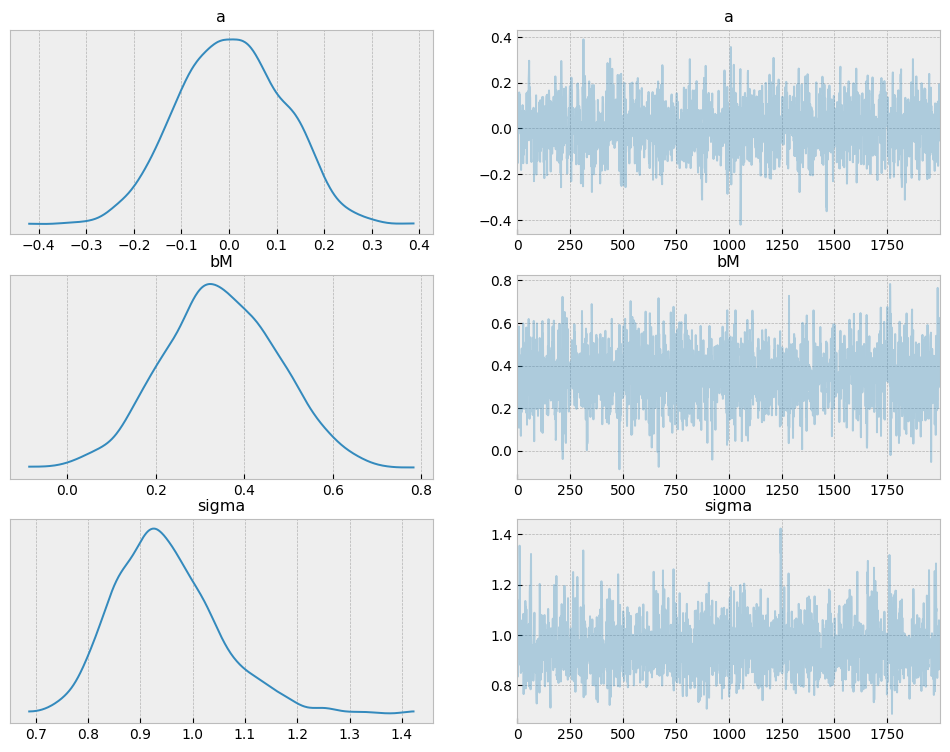

In [17]:
import arviz as az

az.plot_trace(mcmc, figsize=(12,9));

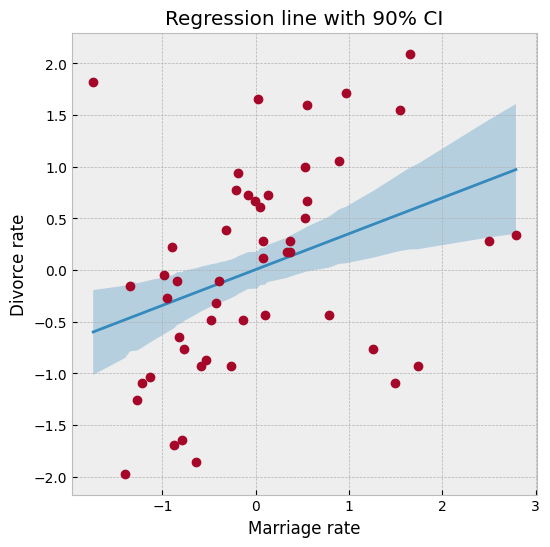

In [42]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax


# Compute empirical posterior distribution over mu by
# computing from the samples
posterior_mu = (
    jnp.expand_dims(samples_1["a"], -1)
    + jnp.expand_dims(samples_1["bM"], -1) * dset.MarriageScaled.values
)  # (50,) - one for each state?

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)  # (2, 50)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI"
);

In [44]:
mean_mu.shape

(50,)

## Prior Predictive Checks

`Predictive` Helper class


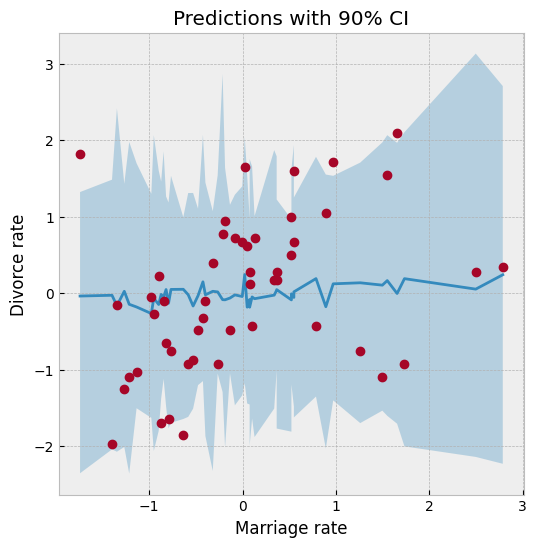

In [45]:

from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, marriage=dset.MarriageScaled.values)[
    "obs"
]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_prior_pred, hpdi_prior_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

## Posterior Predictive

In [46]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]
df = dset.filter(["Location"])
df["Mean Predictions"] = jnp.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,0.016637
1,Alaska,0.502172
2,Arizona,0.024746
3,Arkansas,0.598174
4,California,-0.082400


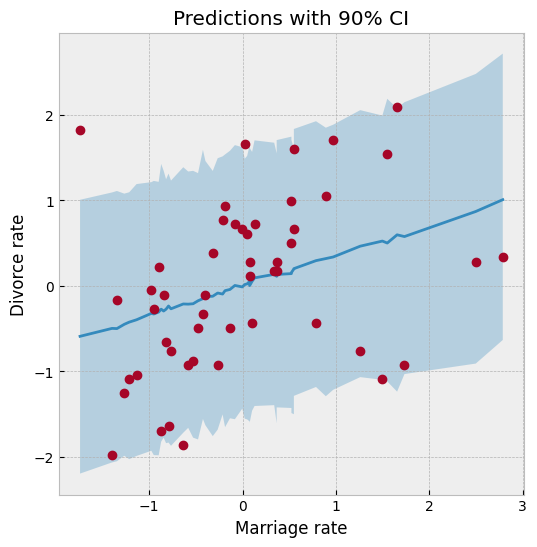

In [49]:

hpdi_pred = hpdi(predictions, 0.9)
mean_pred = jnp.mean(predictions, axis=0)

ax = plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");